In [1]:
## importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer


In [2]:
## Loading Datasets 
train_feat = pd.read_csv('training_set_features.csv') #contains features variables
train_labels = pd.read_csv('training_set_labels.csv') #contains target variables
test_feat = pd.read_csv('test_set_features.csv') #contains unseen data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   xyz_concern                  26615 non-null  float64
 2   xyz_knowledge                26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_xyz              24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

<Axes: >

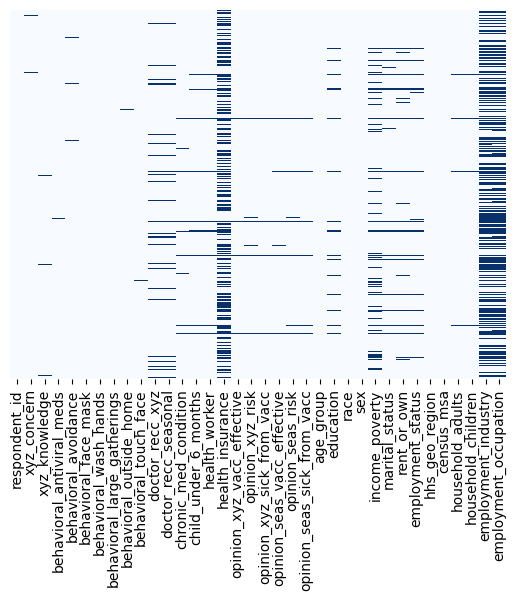

In [3]:
## analysing dataset
print(train_feat.info())
sns.heatmap(train_feat.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=train_feat.columns)

In [4]:
## Data preprocessing (Handling Missing Values and Encoding)
def process(feat):
    # Drop specified columns which has more number of NaN Data
    columns_to_drop = ['health_insurance', 'employment_industry', 'employment_occupation']
    feat = feat.drop(columns=columns_to_drop, errors='ignore')
    
    # Classifying categorical and continuous columns
    cat_cols = [col for col in feat.columns if feat[col].dtype == 'O']
    cont_cols = [col for col in feat.columns if col not in cat_cols]

    # Encode categorical features using LabelEncoder
    for col in cat_cols:
        feat[col] = LabelEncoder().fit_transform(feat[col])
    
    # Define transformers
    numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])

    # Combine transformers into a single ColumnTransformer
    transformer = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, cont_cols),
            ('cat', categorical_transformer, cat_cols)
        ])

    # Fit and transform the data
    feat_processed = transformer.fit_transform(feat)
    
    # Create a DataFrame with the processed features
    processed_columns = cont_cols + cat_cols
    feat_processed = pd.DataFrame(feat_processed, columns=processed_columns)
    return feat_processed
#applying the method to our training set
train_feat_processed = process(train_feat)

print(train_feat_processed.shape)


(26707, 33)


<Axes: >

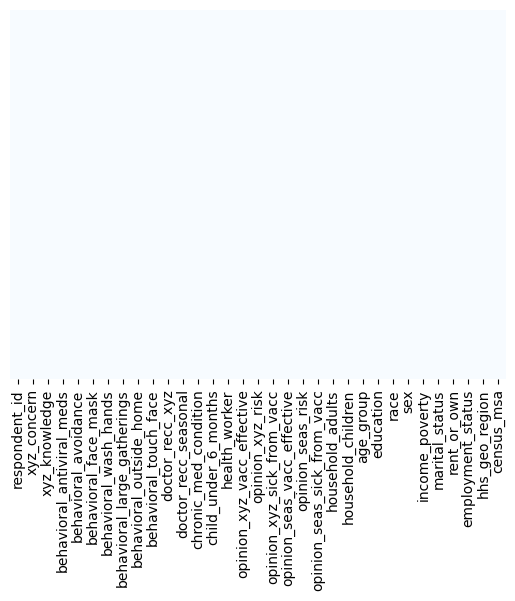

In [5]:
### checking that missing data is handled
sns.heatmap(train_feat_processed.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=train_feat_processed.columns)

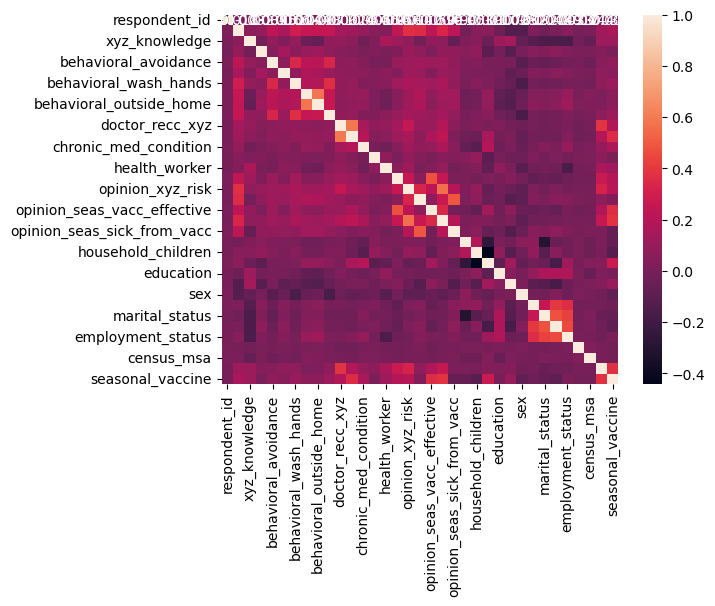

In [6]:
## EDA - Analysing the correlation among columns
import matplotlib.pyplot as plt
import seaborn as sns
train_data = pd.concat([train_feat_processed, train_labels[['xyz_vaccine', 'seasonal_vaccine']]], axis=1)
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

#can't remove any column on basis of this

In [7]:
#ML model training
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Assuming train_feat_processed and train_labels are defined elsewhere
X = train_feat_processed.iloc[:, 1:]  # Remove the 0th column (respondent_id)
y = train_labels[['xyz_vaccine', 'seasonal_vaccine']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the data on Random Forest Classifier 
model_rfc = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model_rfc.fit(X_train, y_train)

# Fitting the data on Logistic Regression 
logreg = MultiOutputClassifier(LogisticRegression(max_iter=10000, random_state=42))
logreg.fit(X_train, y_train)

# Fitting the data on Support Vector Machines
svm = MultiOutputClassifier(SVC(probability=True, random_state=42))
svm.fit(X_train, y_train)


MultiOutputClassifier(estimator=SVC(probability=True, random_state=42))

In [8]:
## AUC ROC SCORES of models
from sklearn.metrics import roc_auc_score

# submission_format file is loaded
submission_format = pd.read_csv('submission_format.csv')

# Predicting probabilities of tested data
y_pred_logreg = logreg.predict_proba(X_test)
y_pred_rfc = model_rfc.predict_proba(X_test)
y_pred_svm = svm.predict_proba(X_test)

# Calculating Mean ROC AUC Scores
mean_roc_auc_svm = (roc_auc_score(y_test['xyz_vaccine'], y_pred_svm[0][:, 1]) +  roc_auc_score(y_test['seasonal_vaccine'], y_pred_svm[1][:, 1])) / 2
mean_roc_auc_logreg = (roc_auc_score(y_test['xyz_vaccine'], y_pred_logreg[0][:, 1]) +  roc_auc_score(y_test['seasonal_vaccine'], y_pred_logreg[1][:, 1])) / 2
mean_roc_auc_rfc = (roc_auc_score(y_test['xyz_vaccine'], y_pred_rfc[0][:, 1]) +  roc_auc_score(y_test['seasonal_vaccine'], y_pred_rfc[1][:, 1])) / 2

#Printing the score
print(f'Mean ROC AUC of SVM: {mean_roc_auc_svm}, LogReg: {mean_roc_auc_logreg}, RFC: {mean_roc_auc_rfc}')


Mean ROC AUC of SVM: 0.8310424417363809, LogReg: 0.8371292364523618, RFC: 0.8410279780887653


In [9]:
#RFC is giving the best ROC AUC score so we are using that to calculate the probabilities
test_feat_processed = process(test_feat)

test = test_feat_processed.iloc[: , 1:] # Removing respondent-id 

y_pred_rfc = svm.predict_proba(test) # predict probability according to RFC

submission_format['xyz_vaccine'] = y_pred_rfc[0][:, 1]  # Probabilities for 'xyz_vaccine'
submission_format['seasonal_vaccine'] = y_pred_rfc[1][:, 1]  # Probabilities for 'seasonal_vaccine'

submission_format.to_csv('submit_final_RFC.csv', index=False) # Convert Pandas DataFrame to CSV File